In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using KernelDensity
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using DSP

In [2]:
FPATH = "../../data/sampling_results/LongRun/"

function marg_mean(name)
    smpl_tmp = bat_read(FPATH*name)
    smpl_tmp = varshape(prior).(smpl_tmp)
    smpl_tmp = unshaped(mean(smpl_tmp))
    return smpl_tmp
end

function marg_std(name)
    smpl_tmp = bat_read(FPATH*name)
    smpl_tmp = varshape(prior).(smpl_tmp)
    smpl_tmp = unshaped(std(smpl_tmp))
    return smpl_tmp
end

function cov_matr(name)
    smpl_tmp = bat_read(FPATH*name)
    smp_fl, w = flatview(unshaped.(smpl_tmp.v)), smpl_tmp.weight
    smp_fl = smp_fl .- mean(smp_fl, FrequencyWeights(w), dims=2)
    cov_m = cov(smp_fl, FrequencyWeights(w), 2)
    return cov_m
end

cov_matr (generic function with 1 method)

In [3]:
β1 = 0.015
β2 = 0.008
β3 = 0.006 
    

prior = NamedTupleDist(
    tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
    ang_spr = [truncated(Normal(4.0, 2.0), 2.0, 6.0), truncated(Normal(4.0, 2.0), 2.0, 6.0)],
    waist = [Normal(2.9, 0.03)],
    algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
    algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
    cam4_ped = 4.0 .. 40.0,
    cam4_light_fluct = 1.0 .. 3.0,
    cam4_light_amp = 1.6 .. 9.9, 
    resx = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
    resy = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
    cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
    cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
    psx = [truncated(Normal(27.1, 27.1*β1), 0., Inf), truncated(Normal(21.6, 21.6*β1), 0., Inf), truncated(Normal(114.0, 114.0*β2), 0., Inf)],
    psy = [truncated(Normal(30.5, 30.5*β1), 0., Inf), truncated(Normal(23.4, 23.4*β1), 0., Inf), truncated(Normal(125.0, 125.0*β2), 0., Inf)],
    cam4_psx = truncated(Normal(121.8, 3*121.8*β3), 0., Inf), 
    cam4_psy = truncated(Normal(120.0, 3*120.0*β3), 0., Inf), 
    light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
    s_cam = [0.0, 1.478, 15.026, 23.1150],
);

labels = [L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", L"s", 
    L"\mu_x", L"\mu_x", L"\mu_x", L"\mu_x", L"\mu_y", L"\mu_y", L"\mu_y", L"\mu_y", 
    "ped", "lf", "a", 
    "res x", "res x", "res x", "res y", "res y", "res y", "res x", "res y", 
    "ps x", "ps x", "ps x", "ps y", "ps y", "ps y", "ps x", "ps y", 
    "la", "la", "la"
    ];

In [4]:
filenames = readdir("../../data/sampling_results/LongRun/")
images = load("../../data/experiment/dataset_2/m2/images-satur.jld2")
hc_mask = [i[1:3] == "hc-" for i in filenames]
hc_fnames = filenames[hc_mask]
hc_eind = parse.(Int64, [i[4:end-5] for i in hc_fnames])
hc_charge = images["charge"][hc_eind]
hc_runind = images["ev_ind"][hc_eind];

In [5]:
filenames = readdir("../../data/sampling_results/LongRun/")
images = load("../../data/experiment/dataset_2/m1/images-satur.jld2")
lc_mask = [i[1:3] == "lc-" for i in filenames]
lc_fnames = filenames[lc_mask]
lc_eind = parse.(Int64, [i[4:end-5] for i in lc_fnames])
lc_charge = images["charge"][lc_eind]
lc_runind = images["ev_ind"][lc_eind];

In [6]:
fnames = [lc_fnames; hc_fnames]
charges = [lc_charge; hc_charge]
runind = [lc_runind ; hc_runind]
charges_n = charges ./ maximum(charges)
runind_n = runind ./ maximum(runind);

In [7]:
msklc = 1:length(lc_fnames)
mskhc = length(lc_fnames)+1:length(lc_fnames)+length(hc_fnames);

In [8]:
charges_n[sortperm(charges_n)] .= 1:length(charges_n)
charges_n = charges_n ./ maximum(charges_n);

## Plot 1: 

In [9]:
samples_name = fnames[20]
event_number = 113

@show samples_name, event_number

(samples_name, event_number) = ("hc-113.hdf5", 113)


("hc-113.hdf5", 113)

In [10]:
cv_tmp = cov_matr(samples_name);

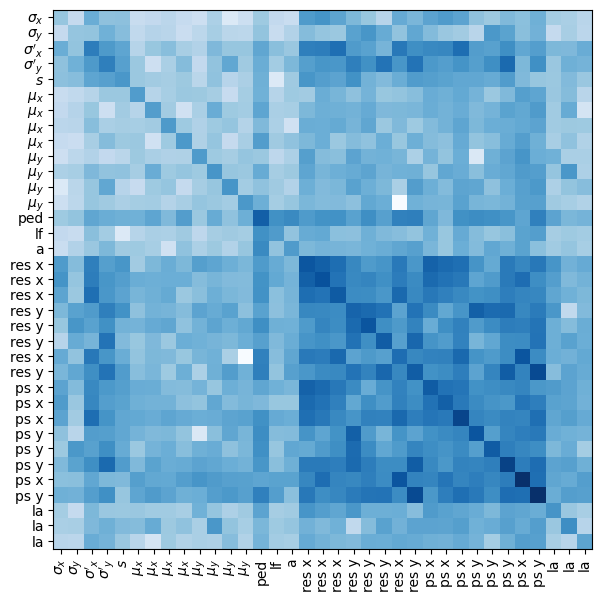

In [11]:
fig, ax = plt.subplots(1,1, figsize=(7,7), )

ax.imshow(log.(abs.(cv_tmp)),  origin="upper", cmap="Blues")

ax.set_yticks(0:34)
ax.set_yticklabels(labels)

ax.set_xticks(0:34)
ax.set_xticklabels(labels, rotation = 90);

## Plot 2: 

In [12]:
conv_mat = load("../../data/experiment/dataset_2/m2/conv-matrix-upd-1.jld2")

conv_matrices = (
    cam_1 = conv_mat["cam_1"],
    cam_2 = conv_mat["cam_2"],
    cam_3 = conv_mat["cam_3"],
    cam_4 = conv_mat["cam_4"], 
) 

images = load("../../data/experiment/dataset_2/m2/images-satur.jld2");

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);

In [13]:
include("../likelihood.jl")
include("../utill.jl");

In [14]:
samples = bat_read(FPATH*samples_name)
samples = varshape(prior).(samples);

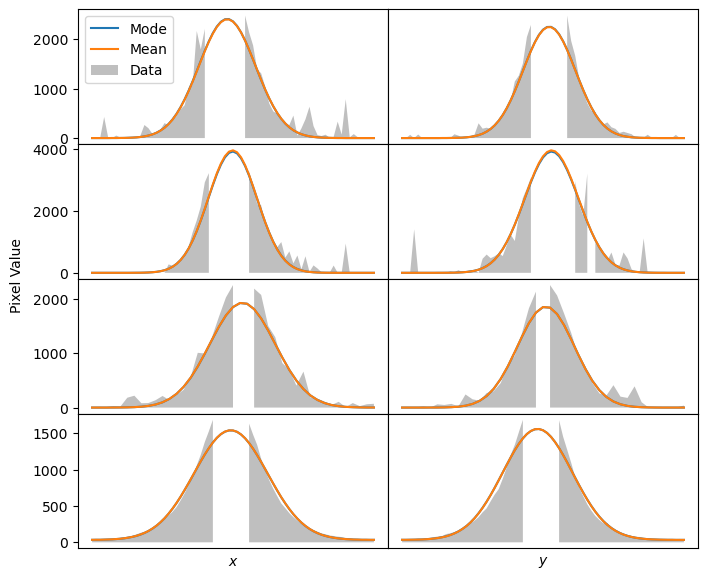

PyObject Text(0.04, 0.5, 'Pixel Value')

In [15]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_crossections(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

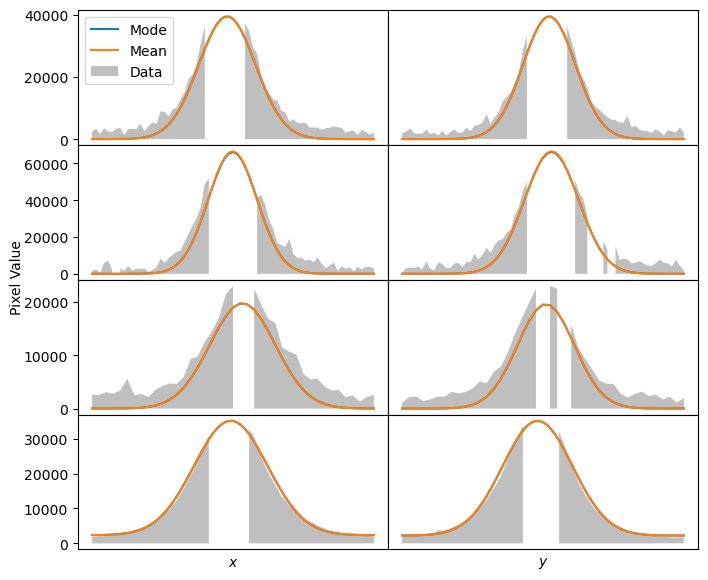

PyObject Text(0.04, 0.5, 'Pixel Value')

In [16]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_integral(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

## Plot 3: 

In [17]:
mean_params =  [marg_mean(i) for i in fnames[mskhc]]
mean_matr = hcat(mean_params...);

In [18]:
cv = mean_matr .- mean(mean_matr, dims=2)
cv = cv * cv';

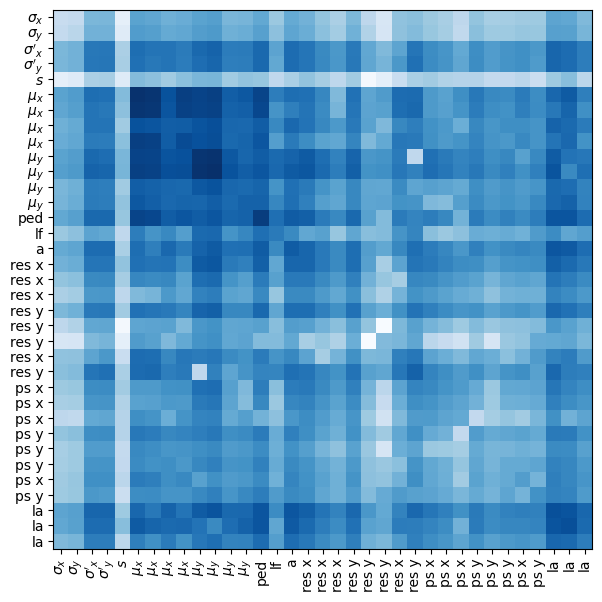

In [19]:
fig, ax = plt.subplots(1,1, figsize=(7,7), )

ax.imshow(log.(abs.(cv)),  origin="upper", cmap="Blues")

ax.set_yticks(0:34)
ax.set_yticklabels(labels)

ax.set_xticks(0:34)
ax.set_xticklabels(labels, rotation = 90);

## Plot 4: 

In [20]:
mean_params =  [marg_std(i) for i in fnames[mskhc]]
mean_matr = hcat(mean_params...);

In [21]:
cv = mean_matr .- mean(mean_matr, dims=2)
cv = cv * cv';

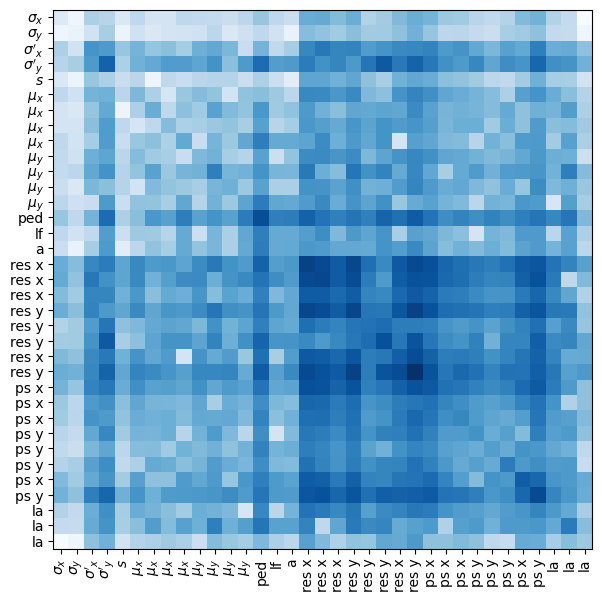

In [22]:
fig, ax = plt.subplots(1,1, figsize=(7,7), )

ax.imshow(log.(abs.(cv)),  origin="upper", cmap="Blues")

ax.set_yticks(0:34)
ax.set_yticklabels(labels)

ax.set_xticks(0:34)
ax.set_xticklabels(labels, rotation = 90);